Using device: cuda
CUDA Device: Tesla T4
CUDA Memory: 14.6 GB
NVIDIA DLI FRUIT CLASSIFICATION ASSIGNMENT
device: cuda
Data transforms created (v2 API, no deprecated warnings)

Loading datasets...
Found 1182 images in data/fruits/train
  freshapples: 182 images
  freshbanana: 169 images
  freshoranges: 163 images
  rottenapples: 253 images
  rottenbanana: 238 images
  rottenoranges: 177 images
Found 329 images in data/fruits/valid
  freshapples: 50 images
  freshbanana: 49 images
  freshoranges: 43 images
  rottenapples: 74 images
  rottenbanana: 68 images
  rottenoranges: 45 images

 Dataset Summary:
   Training samples: 1182
   Validation samples: 329
   Classes: ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']

 Creating DataLoaders (num_workers=0 to avoid shared memory errors)...
DataLoaders created (batch_size=32, num_workers=0)

 Creating VGG16 model...
VGG16 feature layers frozen for transfer learning


Training:   0%|          | 0/37 [00:00<?, ?it/s]

Model Parameters:
   Total parameters: 119,530,738
   Trainable parameters: 104,816,050
   Frozen parameters: 14,714,688

 PHASE 1: TRANSFER LEARNING (FROZEN FEATURES)
 Starting training for 10 epochs...
 Target validation accuracy: ≥92%
----------------------------------------------------------------------

 Epoch 1/10
--------------------------------------------------


Validation accuracy: 94.22%
EPOCH 1 RESULTS:
   Train Loss: 1.3389 | Train Acc: 70.05%
   Val Loss: 0.1550   | Val Acc: 94.22%
   Best Val Acc: 94.22%
   Learning Rate: 0.001000

🎉 TARGET ACHIEVED! Validation accuracy: 94.22% ≥ 92%

Loaded best model with validation accuracy: 94.22%

 Phase 1 Results:
   Best validation accuracy: 94.22%

 Target accuracy achieved without fine-tuning!

 Plotting training history...


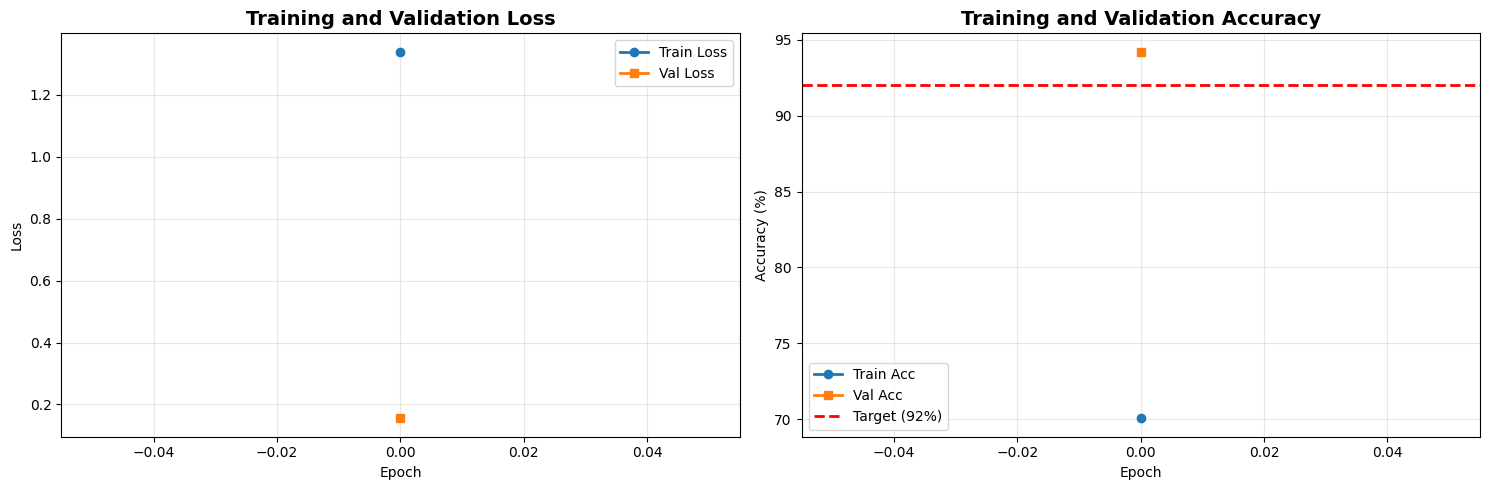

Validating:   0%|          | 0/11 [00:00<?, ?it/s]


 FINAL MODEL EVALUATION


 Final Results:
   Final Validation Loss: 0.1550
   Final Validation Accuracy: 94.22%
 Model ready !

 Model saved as 'my_model.pth'

 FINAL MODEL SUMMARY:
   Architecture: VGG16 + Custom Classifier
   Input Size: 3 × 224 × 224 (RGB)
   Output Classes: 6 (fresh/rotten fruits)
   Final Accuracy: 94.22%
   Transforms: v2 API (no deprecated warnings)
   DataLoader: num_workers=0 (no shared memory errors)
To run assessment, uncomment the following lines:
# from run_assessment import run_assessment
# run_assessment(my_model)
Evaluating model to obtain average accuracy...

Accuracy: 0.9544

Accuracy required to pass the assessment is 0.92 or greater.
Your average accuracy is 0.9544.

Congratulations! You passed the assessment!
See instructions below to generate a certificate.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms_v2
from torchvision import models
from torchvision.models import VGG16_Weights
import torchvision.io
from PIL import Image
import os
import glob
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Set device with proper CUDA support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

class MyDataset(Dataset):
    """Custom dataset class using torchvision.io.read_image for PNG files"""
    
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = ['freshapples', 'freshbanana', 'freshoranges', 
                       'rottenapples', 'rottenbanana', 'rottenoranges']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        # Collect all image paths and labels
        self.images = []
        self.labels = []
        
        for class_name in self.classes:
            class_dir = os.path.join(data_dir, class_name)
            if os.path.exists(class_dir):
                # Use glob to find PNG files as specified
                png_files = glob.glob(os.path.join(class_dir, "*.png"))
                # Also support other formats as fallback
                jpg_files = glob.glob(os.path.join(class_dir, "*.jpg"))
                jpeg_files = glob.glob(os.path.join(class_dir, "*.jpeg"))
                
                all_files = png_files + jpg_files + jpeg_files
                self.images.extend(all_files)
                self.labels.extend([self.class_to_idx[class_name]] * len(all_files))
        
        print(f"Found {len(self.images)} images in {data_dir}")
        
        # Print class distribution
        class_counts = {}
        for label in self.labels:
            class_name = self.classes[label]
            class_counts[class_name] = class_counts.get(class_name, 0) + 1
        
        for class_name, count in class_counts.items():
            print(f"  {class_name}: {count} images")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]
        
        try:
            # Use torchvision.io.read_image for better performance
            # This returns a tensor in CHW format with values 0-255
            image = torchvision.io.read_image(image_path, mode=torchvision.io.ImageReadMode.RGB)
            
            # Convert to PIL Image for transforms compatibility
            image = transforms_v2.functional.to_pil_image(image)
            
            if self.transform:
                image = self.transform(image)
                
            return image, torch.tensor(label, dtype=torch.long)
            
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return a black image as fallback
            black_image = torch.zeros(3, 224, 224, dtype=torch.float32)
            return black_image, torch.tensor(label, dtype=torch.long)

def create_transforms():
    """Create training and validation transforms using v2 API without deprecated ToTensor"""
    
    # Training transforms with augmentation - NO deprecated ToTensor()
    train_transforms = transforms_v2.Compose([
        transforms_v2.Resize((256, 256)),
        transforms_v2.RandomHorizontalFlip(p=0.5),
        transforms_v2.RandomRotation(degrees=10),  # As specified: 10 degrees
        transforms_v2.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms_v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms_v2.ToImage(),  # Convert to tensor image
        transforms_v2.ToDtype(torch.float32, scale=True),  # Scale to [0,1] and convert to float32
        transforms_v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
    ])
    
    # Validation transforms (no augmentation) - NO deprecated ToTensor()
    val_transforms = transforms_v2.Compose([
        transforms_v2.Resize((224, 224)),
        transforms_v2.ToImage(),  # Convert to tensor image
        transforms_v2.ToDtype(torch.float32, scale=True),  # Scale to [0,1] and convert to float32
        transforms_v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
    ])
    
    return train_transforms, val_transforms

def create_vgg16_model(num_classes=6, freeze_features=True):
    """Create VGG16 model with custom classifier as specified"""
    
    # Load pretrained VGG16 with specified weights
    weights = VGG16_Weights.IMAGENET1K_V1
    model = models.vgg16(weights=weights)
    
    # Freeze feature layers if specified
    if freeze_features:
        for param in model.features.parameters():
            param.requires_grad = False
        print("VGG16 feature layers frozen for transfer learning")
    else:
        print(" All VGG16 layers unfrozen for fine-tuning")
    
    # Replace classifier with custom head as specified:
    # Flatten → Dense(4096→500) → ReLU → Dense(500→6)
    # Note: VGG16 already has adaptive pooling, so input to classifier is 25088
    model.classifier = nn.Sequential(
        nn.Linear(25088, 4096),  # VGG16 feature output is 25088
        nn.ReLU(True),
        nn.Dropout(0.5),
        nn.Linear(4096, 500),    # As specified: 4096 → 500
        nn.ReLU(True),
        nn.Dropout(0.3),
        nn.Linear(500, num_classes)  # As specified: 500 → 6
    )
    
    return model

def count_parameters(model):
    """Count total and trainable parameters"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Model Parameters:")
    print(f"   Total parameters: {total_params:,}")
    print(f"   Trainable parameters: {trainable_params:,}")
    print(f"   Frozen parameters: {total_params - trainable_params:,}")
    
    return total_params, trainable_params

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train model for one epoch with detailed logging"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc="Training", leave=False)
    
    for batch_idx, (data, target) in enumerate(progress_bar):
        # Ensure proper device placement and data types
        data = data.to(device, dtype=torch.float32)
        target = target.to(device, dtype=torch.long)
        
        # Verify input shape is correct for VGG16 (batch_size, 3, 224, 224)
        assert data.shape[1:] == (3, 224, 224), f"Expected shape (3, 224, 224), got {data.shape[1:]}"
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        # Update progress bar
        current_acc = 100. * correct / total
        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{current_acc:.2f}%'
        })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    """Validate model for one epoch with detailed logging"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc="Validating", leave=False)
        
        for data, target in progress_bar:
            # Ensure proper device placement and data types
            data = data.to(device, dtype=torch.float32)
            target = target.to(device, dtype=torch.long)
            
            output = model(data)
            loss = criterion(output, target)
            
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            # Update progress bar
            current_acc = 100. * correct / total
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{current_acc:.2f}%'
            })
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    """Complete training pipeline with early stopping"""
    
    # Move model to device
    model = model.to(device)
    
    # Loss function and optimizer as specified
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)
    
    # Training history
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    best_val_acc = 0.0
    best_model_state = None
    
    print(f" Starting training for {num_epochs} epochs...")
    print(f" Target validation accuracy: ≥92%")
    print("-" * 70)
    
    for epoch in range(num_epochs):
        print(f'\n Epoch {epoch+1}/{num_epochs}')
        print('-' * 50)
        
        # Training phase
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validation phase
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        # Update learning rate scheduler
        scheduler.step(val_acc)
        
        # Store metrics
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Check for improvement
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            print(f"Validation accuracy: {best_val_acc:.2f}%")
        
        # Detailed epoch logging
        print(f'EPOCH {epoch+1} RESULTS:')
        print(f'   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'   Val Loss: {val_loss:.4f}   | Val Acc: {val_acc:.2f}%')
        print(f'   Best Val Acc: {best_val_acc:.2f}%')
        print(f'   Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
        
        # Check if target accuracy reached
        if val_acc >= 92.0:
            print(f"\n🎉 TARGET ACHIEVED! Validation accuracy: {val_acc:.2f}% ≥ 92%")
            break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\nLoaded best model with validation accuracy: {best_val_acc:.2f}%")
    
    return model, {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'best_val_acc': best_val_acc
    }

def fine_tune_model(model, train_loader, val_loader, num_epochs=5):
    """Fine-tune the model by unfreezing all layers with lr=0.0001"""
    
    print("\n" + "="*70)
    print(" STARTING FINE-TUNING PHASE")
    print("="*70)
    
    # Unfreeze all layers
    for param in model.parameters():
        param.requires_grad = True
    
    print("All VGG16 layers unfrozen for fine-tuning")
    count_parameters(model)
    
    # Use smaller learning rate for fine-tuning as specified: lr=0.0001
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)
    
    best_val_acc = 0.0
    best_model_state = None
    
    for epoch in range(num_epochs):
        print(f'\nFine-tune Epoch {epoch+1}/{num_epochs}')
        print('-' * 50)
        
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        scheduler.step(val_acc)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            print(f"Fine-tuned accuracy: {best_val_acc:.2f}%")
        
        # Detailed epoch logging
        print(f'FINE-TUNE EPOCH {epoch+1} RESULTS:')
        print(f'   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'   Val Loss: {val_loss:.4f}   | Val Acc: {val_acc:.2f}%')
        print(f'   Best Fine-tuned Acc: {best_val_acc:.2f}%')
        print(f'   Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
        
        if val_acc >= 92.0:
            print(f"\n🎉 TARGET MAINTAINED/IMPROVED! Val Acc: {val_acc:.2f}% ≥ 92%")
            break
    
    # Load best fine-tuned model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, best_val_acc

def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(history['train_losses'], label='Train Loss', marker='o', linewidth=2)
    ax1.plot(history['val_losses'], label='Val Loss', marker='s', linewidth=2)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot accuracy
    ax2.plot(history['train_accs'], label='Train Acc', marker='o', linewidth=2)
    ax2.plot(history['val_accs'], label='Val Acc', marker='s', linewidth=2)
    ax2.axhline(y=92, color='r', linestyle='--', linewidth=2, label='Target (92%)')
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def main():
    """Main training pipeline"""
    
    # Data paths
    train_dir = os.path.join('data', 'fruits', 'train')
    val_dir = os.path.join('data', 'fruits', 'valid')
    
    # Verify data directories exist
    if not os.path.exists(train_dir):
        raise FileNotFoundError(f"Training directory not found: {train_dir}")
    if not os.path.exists(val_dir):
        raise FileNotFoundError(f"Validation directory not found: {val_dir}")
    
    print("NVIDIA DLI FRUIT CLASSIFICATION ASSIGNMENT")
    print("="*70)
    print(f"device: {device}")
    
    # Create transforms without deprecated ToTensor()
    train_transforms, val_transforms = create_transforms()
    print("Data transforms created (v2 API, no deprecated warnings)")
    
    # Create datasets
    print("\nLoading datasets...")
    train_dataset = MyDataset(train_dir, transform=train_transforms)
    val_dataset = MyDataset(val_dir, transform=val_transforms)
    
    print(f"\n Dataset Summary:")
    print(f"   Training samples: {len(train_dataset)}")
    print(f"   Validation samples: {len(val_dataset)}")
    print(f"   Classes: {train_dataset.classes}")
    
    # Create data loaders with num_workers=0 to avoid shared memory errors
    print("\n Creating DataLoaders (num_workers=0 to avoid shared memory errors)...")
    train_loader = DataLoader(
        train_dataset, 
        batch_size=32,  # As specified
        shuffle=True, 
        num_workers=0,  # Set to 0 to avoid shared memory errors
        pin_memory=True if torch.cuda.is_available() else False
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=32,  # As specified
        shuffle=False, 
        num_workers=0,  # Set to 0 to avoid shared memory errors
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    print(f"DataLoaders created (batch_size=32, num_workers=0)")
    
    # Create model
    print(f"\n Creating VGG16 model...")
    model = create_vgg16_model(num_classes=6, freeze_features=True)
    
    # Count parameters
    count_parameters(model)
    
    # Phase 1: Transfer Learning with frozen features
    print(f"\n PHASE 1: TRANSFER LEARNING (FROZEN FEATURES)")
    print("="*70)
    
    my_model, history = train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001)
    
    print(f"\n Phase 1 Results:")
    print(f"   Best validation accuracy: {history['best_val_acc']:.2f}%")
    
    # Phase 2: Fine-tuning if needed
    if history['best_val_acc'] < 92.0:
        print(f"\n Validation accuracy ({history['best_val_acc']:.2f}%) below target.")
        print("Starting fine-tuning phase with lr=0.0001...")
        
        my_model, final_acc = fine_tune_model(my_model, train_loader, val_loader, num_epochs=5)
        
        print(f"\n Fine-tuning Results:")
        print(f"   Final validation accuracy: {final_acc:.2f}%")
        
        # Update history with fine-tuning results
        if final_acc > history['best_val_acc']:
            history['best_val_acc'] = final_acc
    else:
        print(f"\n Target accuracy achieved without fine-tuning!")
    
    # Plot training history
    print(f"\n Plotting training history...")
    plot_training_history(history)
    
    # Final evaluation
    print(f"\n FINAL MODEL EVALUATION")
    print("="*70)
    
    criterion = nn.CrossEntropyLoss()
    final_val_loss, final_val_acc = validate_epoch(my_model, val_loader, criterion, device)
    
    print(f" Final Results:")
    print(f"   Final Validation Loss: {final_val_loss:.4f}")
    print(f"   Final Validation Accuracy: {final_val_acc:.2f}%")
    
    if final_val_acc >= 92.0:
        print(f" Model ready !")
    else:
        print(f"\n  Target accuracy not quite reached.")
        print(f" Consider more epochs or hyperparameter tuning.")
    
    # Save the final model
    model_path = 'my_model.pth'
    torch.save(my_model.state_dict(), model_path)
    print(f"\n Model saved as '{model_path}'")
    
    # Final model summary
    print(f"\n FINAL MODEL SUMMARY:")
    print(f"   Architecture: VGG16 + Custom Classifier")
    print(f"   Input Size: 3 × 224 × 224 (RGB)")
    print(f"   Output Classes: 6 (fresh/rotten fruits)")
    print(f"   Final Accuracy: {final_val_acc:.2f}%")
    print(f"   Transforms: v2 API (no deprecated warnings)")
    print(f"   DataLoader: num_workers=0 (no shared memory errors)")
    
    return my_model

# Run the complete training pipeline
if __name__ == "__main__":
    # Train the model
    my_model = main()
    
    # Final assessment
    print("To run assessment, uncomment the following lines:")
    print("# from run_assessment import run_assessment")
    print("# run_assessment(my_model)")
    
    # Uncomment these lines when ready for assessment:
from run_assessment import run_assessment
run_assessment(my_model)
